In [129]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [130]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

len_languages = len(languages)

In [131]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [132]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names\Arabic.txt
data/names\Chinese.txt
data/names\Czech.txt
data/names\Dutch.txt
data/names\English.txt
data/names\French.txt
data/names\German.txt
data/names\Greek.txt
data/names\Irish.txt
data/names\Italian.txt
data/names\Japanese.txt
data/names\Korean.txt
data/names\Polish.txt
data/names\Portuguese.txt
data/names\Russian.txt
data/names\Scottish.txt
data/names\Spanish.txt
data/names\Vietnamese.txt


In [133]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [134]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbas,English
1,Abbey,English
2,Abbott,English
3,Abdi,English
4,Abel,English


In [135]:
len(names.loc[(names['lang'] == 'French')])

277

In [136]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [137]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [138]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [139]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    "Returns list of one-hot character arrays"
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with [0 0 ... 1]
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y


def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

In [140]:
np.array(name_representation('Andi', maxlen)).shape

(18, 74)

In [141]:
lang_representation('English', language_to_index)

array([1., 0., 0., 0., 0.])

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the **names and language** into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [236]:
test_split = 0.2

# Shuffle and split names data
shuffled_names = names.sample(frac=1)
train, test = train_test_split(shuffled_names, test_size=test_split)

In [235]:
print(len(train))
print(len(test))

4540
1136


In [143]:
for entry in train:
    print(type(entry))

<class 'str'>
<class 'str'>


In [144]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = np.empty((len(train), maxlen, len_alphabet))
Y_train = np.empty((len(train), len_languages))

for i, (pd_idx, pd_row) in enumerate(train.iterrows()):
    X_train[i] = np.array(name_representation(pd_row['name'], maxlen))
    Y_train[i] = np.array(lang_representation(pd_row['lang'], language_to_index))


X_test = np.empty((len(test), maxlen, len_alphabet))
Y_test = np.empty((len(test), len_languages))

for i, (pd_idx, pd_row) in enumerate(test.iterrows()):
    X_test[i] = np.array(name_representation(pd_row['name'], maxlen))
    Y_test[i] = np.array(lang_representation(pd_row['lang'], language_to_index))

### END YOUR CODE

Possibly, pack the data into a Dataset (e.g. when working with in PyTorch)

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [179]:
### START YOUR CODE
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense 

# SimpleRNN, single layer with tf.keras....

hidden_size = 64

model = Sequential()
model.add(SimpleRNN(units=hidden_size, input_shape=(maxlen, len_alphabet)))
model.add(Dense(units=len_languages, activation='softmax'))
model.summary()


### END YOUR CODE

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 64)                8896      
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                                                 
Total params: 9,221
Trainable params: 9,221
Non-trainable params: 0
_________________________________________________________________


In [180]:
### START YOUR CODE
from keras.optimizers import Adam
optimizer = Adam(lr=0.0005)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics="accuracy")


batch_size=64
nepochs = 100

log_64_opt = model.fit(X_train, Y_train, 
                validation_data=(X_test, Y_test),
                batch_size=batch_size, epochs=nepochs,
                use_multiprocessing=True)

### END YOUR CODE

Epoch 1/100
71/71 [==============================] - 1s 6ms/step - loss: 1.1363 - accuracy: 0.6200 - val_loss: 1.0655 - val_accuracy: 0.6540
Epoch 2/100
71/71 [==============================] - 0s 4ms/step - loss: 1.0045 - accuracy: 0.6641 - val_loss: 0.9075 - val_accuracy: 0.7033
Epoch 3/100
71/71 [==============================] - 0s 4ms/step - loss: 0.8662 - accuracy: 0.7022 - val_loss: 0.8321 - val_accuracy: 0.7148
Epoch 4/100
71/71 [==============================] - 0s 3ms/step - loss: 0.8045 - accuracy: 0.7097 - val_loss: 0.7501 - val_accuracy: 0.7350
Epoch 5/100
71/71 [==============================] - 0s 3ms/step - loss: 0.7525 - accuracy: 0.7403 - val_loss: 0.7081 - val_accuracy: 0.7500
Epoch 6/100
71/71 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.7504 - val_loss: 0.6827 - val_accuracy: 0.7570
Epoch 7/100
71/71 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.7630 - val_loss: 0.6686 - val_accuracy: 0.7588
Epoch 8/100
7

Plot Training Logs

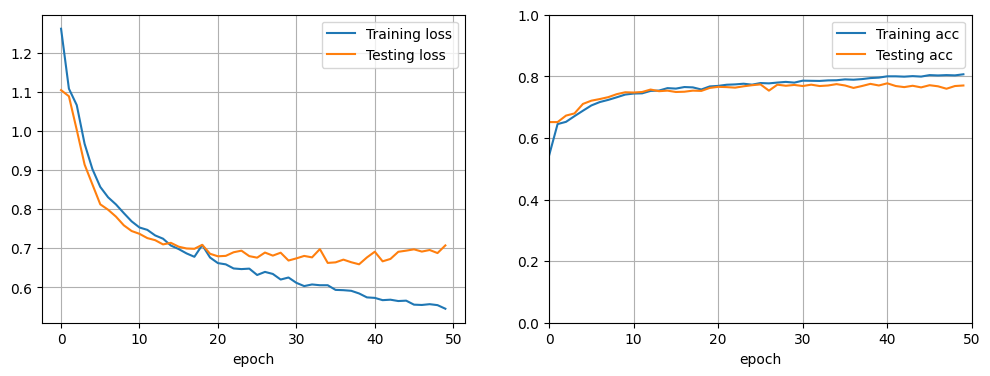

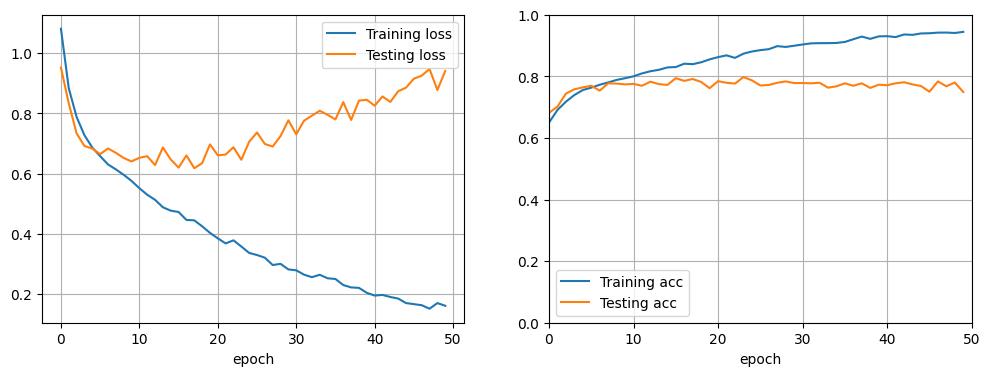

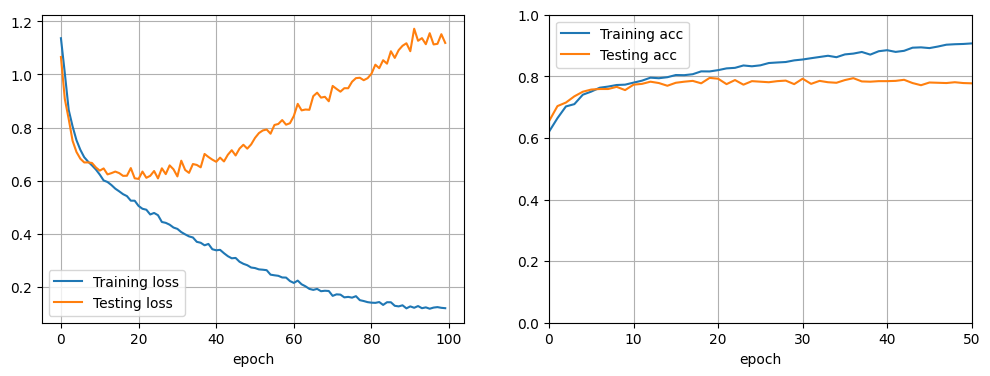

In [233]:
logs = [log_20, log_64, log_64_opt]
for log in logs:

    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Testing loss')
    ax1.set_xlabel('epoch')
    ax1.legend()
    ax1.grid()

    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Testing acc')
    ax2.set_xlabel('epoch')
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0,50)
    ax2.legend()
    ax2.grid()

1st figure shows results for hidden_size=20 (good choice for lesser overfitting)

2nd figure shows results for hidden_size=64

3rd figure shows results for params from lecture: Trained with Adam (lr = 0.0005), batchsize =64 
hidden_size=64. Looks quite different in Keras. Slides point towards differing initialization strategies (Glorot in Keras, Kaiming in PyTorch). 

#### Findings

Both choices of `hidden_size` lead to same validation accuracy after 50 epochs, but higher output dimensionality of the hidden RNN layer leads to faster overfitting (~3x more parameters -> higher model flexibility -> more overfitting)

Decreasing  `batch_size` doesn't have a significant effect, other than taking longer to train.

In the initial data exploration section, we see that 65% of the data points have the label `lang=English`. Given this class imbalance, 75% accuracy isn't a great result, as a predictor with the constant output 'English' would already achieve 65% accuracy. 

36/36 [==============================] - 0s 1ms/step


<Axes: >

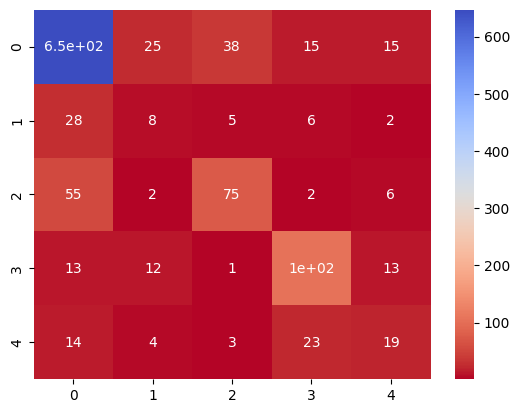

In [210]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

y_test = np.argmax(Y_test, axis=1)

from seaborn import heatmap
conf = confusion_matrix(y_test, y_pred)
heatmap(conf, annot=True, cmap='coolwarm_r')

In [212]:
language_to_index

{'English': 0, 'French': 1, 'German': 2, 'Italian': 3, 'Spanish': 4}

Very bad to bad classification of languages other than english as a result of class imbalance

### Implement Model with several SimpleRNN Layers

In [240]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense 


hidden_size = 32

model = Sequential()
model.add(SimpleRNN(units=hidden_size, input_shape=(maxlen, len_alphabet), \
                    return_sequences=True))
model.add(SimpleRNN(units=hidden_size, \
                    return_sequences=True))
model.add(SimpleRNN(units=hidden_size, \
                    return_sequences=False))
model.add(Dense(units=len_languages, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 18, 32)            3424      
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 18, 32)            2080      
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 5)                 165       
                                                                 
Total params: 7,749
Trainable params: 7,749
Non-trainable params: 0
_________________________________________________________________


In [241]:
batch_size=64
nepochs = 50

log = model.fit(X_train, Y_train, 
                validation_data=(X_test, Y_test),
                batch_size=batch_size, epochs=nepochs,
                use_multiprocessing=True)

Epoch 1/50
71/71 [==============================] - 3s 23ms/step - loss: 1.1581 - accuracy: 0.6174 - val_loss: 1.0835 - val_accuracy: 0.6514
Epoch 2/50
71/71 [==============================] - 0s 7ms/step - loss: 1.0522 - accuracy: 0.6487 - val_loss: 0.9961 - val_accuracy: 0.6655
Epoch 3/50
71/71 [==============================] - 0s 7ms/step - loss: 0.9194 - accuracy: 0.6894 - val_loss: 0.8424 - val_accuracy: 0.7245
Epoch 4/50
71/71 [==============================] - 0s 7ms/step - loss: 0.8059 - accuracy: 0.7273 - val_loss: 0.7699 - val_accuracy: 0.7465
Epoch 5/50
71/71 [==============================] - 0s 6ms/step - loss: 0.7425 - accuracy: 0.7445 - val_loss: 0.7219 - val_accuracy: 0.7518
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.6993 - accuracy: 0.7559 - val_loss: 0.7264 - val_accuracy: 0.7526
Epoch 7/50
71/71 [==============================] - 0s 7ms/step - loss: 0.6649 - accuracy: 0.7648 - val_loss: 0.6975 - val_accuracy: 0.7544
Epoch 8/50
71/71 [=

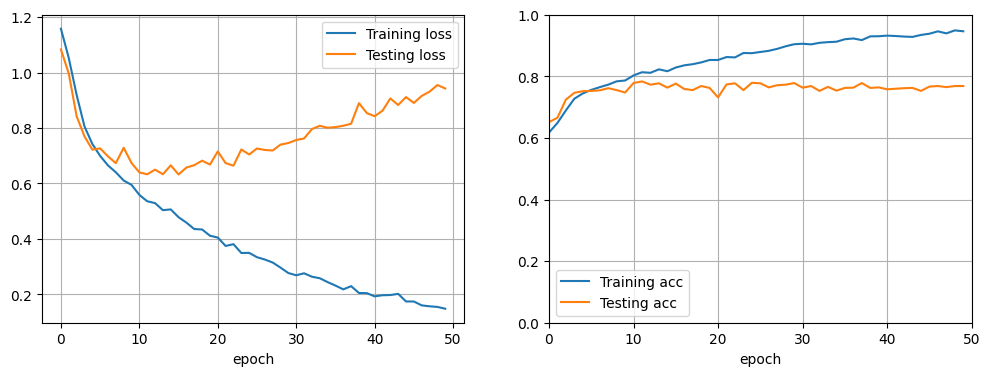

In [242]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.grid()

ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.set_xlabel('epoch')
ax2.set_ylim(0, 1)
ax2.set_xlim(0,50)
ax2.legend()
ax2.grid()

#### Findings

No accuracy gain over single RNN layer. Lecture did show significant improvement with same configuration used. Cannot explain this.


### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

In [ ]:
### START YOUR CODE

# train...

### END YOUR CODE